# Train some models and get their scores

In [1]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
import text_package

HAM = 'ham'
SPAM = 'spam'
SUBJECT = 'Subject'
CONTENT = 'Content'
BOTH = 'Both'
CLASS = 'Class'
ACCURACY = 'Accuracy'
PRECISION = 'Precision'
RECALL = 'recall'
F1 = 'f1'

# Try this on the whole train set
train_list = text_package.get_text_from_csv('train.csv')
# Create the CountVectorizer object
simple_vectorizer = CountVectorizer()


# Create a model class with its name, the feature used, and the scores
class Model:
    def __init__(self, model_arg, feature_arg, accuracy_arg, precision_arg, recall_arg, f1_arg):
        self.model_name = model_arg
        self.feature = feature_arg
        self.accuracy = accuracy_arg
        self.precision = precision_arg
        self.recall = recall_arg
        self.f1 = f1_arg


# Create the model and get the scores, depending on which type
def create_model_errors(feature, logistic_regression=False, svm_mod=False, nb=False,
                        k_for_nn=0, estimators=0, knn=False, adaboost=False):
    # Fit and transform the vector depending on the feature that's sent
    vector = simple_vectorizer.fit_transform(train_list[feature].values)

    # Built the model depending on its type
    if logistic_regression:
        model = LogisticRegression()
    if svm_mod:
        model = svm.SVC(kernel='linear')
    if nb:
        model = MultinomialNB()
    if knn:
        model = KNeighborsClassifier(n_neighbors=k_for_nn)
    if adaboost:
        model = AdaBoostClassifier(n_estimators=estimators)

    # Model name depending on the type
    model_name = 'log_reg'*logistic_regression + 'svm'*svm_mod + 'nb'*nb + 'knn'*knn + 'adaboost'*adaboost
    # Obtain the parameter for print purposes
    parameter = ''*logistic_regression + ''*svm_mod + ''*nb + str(k_for_nn)*knn + str(estimators)*adaboost

    # Calculate accuracy, precision, recall and f1
    accuracy = np.mean(cross_val_score(model, vector, train_list[CLASS], cv=4, scoring='accuracy'))
    precision = np.mean(cross_val_score(model, vector, train_list[CLASS], cv=4, scoring='precision_weighted'))
    recall = np.mean(cross_val_score(model, vector, train_list[CLASS], cv=4, scoring='recall_weighted'))
    f1 = np.mean(cross_val_score(model, vector, train_list[CLASS], cv=4, scoring='f1_weighted'))
    
    # The model name is changed to contain the model type, the feature used and the value of the eventual parameters
    model_name = model_name+'_'+feature+str(parameter)
    
    # Save the model which is trained on the data
    pickle.dump(model.fit(vector, train_list[CLASS]), open(model_name+'.sav', 'wb'))
    
    # Return the model
    return Model(model_name, feature, accuracy, precision, recall, f1)


# Build the error array (same build function as always)
def get_errors_array(model_errors, errors_array):
    rows_errors = []
    index_errors = []
    rows_errors.append({ACCURACY: model_errors.accuracy,
                        PRECISION: model_errors.precision,
                        RECALL: model_errors.recall,
                        F1: model_errors.f1})
    index_errors.append(model_errors.model_name)
    data_errors = pd.DataFrame(rows_errors, index=index_errors)
    errors_array[model_errors.feature] = errors_array[model_errors.feature].append(data_errors)

    return errors_array

errors_email = {SUBJECT: pd.DataFrame({ACCURACY: [],
                                       PRECISION: [],
                                       RECALL: [],
                                       F1: []})}
errors_email[CONTENT] = errors_email[SUBJECT]

feature_email_list = [SUBJECT, CONTENT]

k_list = [1, 5, 10]
ada_estimators = [5, 10]

for feature_email in feature_email_list:
    # We try to get the errors with 8 different models:
    # logistic regression, Multinomial Naive Bayes, Linear SVM, 
    # knn with k=1, 5 and 10 and adaboost with 5 and 10 estimators
    errors_email = get_errors_array(create_model_errors(feature_email, logistic_regression=True), errors_email)
    errors_email = get_errors_array(create_model_errors(feature_email, nb=True), errors_email)
    errors_email = get_errors_array(create_model_errors(feature_email, svm_mod=True), errors_email)
    for k in k_list:
        errors_email = get_errors_array(create_model_errors(feature_email, knn=True, k_for_nn=k), errors_email)
    for ada in ada_estimators:
        errors_email = get_errors_array(create_model_errors(feature_email, adaboost=True, estimators=ada), errors_email)
        
    # Again re-order the data frame    
    errors_email[feature_email] = errors_email[feature_email][errors_email[feature_email].columns.tolist()[0:1] +
                                                              errors_email[feature_email].columns.tolist()[2:4] +
                                                              errors_email[feature_email].columns.tolist()[1:2]]
    # Order it by accuracy
    errors_email[feature_email] = errors_email[feature_email].sort_values(ACCURACY, ascending=False)

# Try it with the subject text feature
errors_email[SUBJECT].head(8)

,Accuracy,f1,recall,Precision
log_reg_Subject,0.918771,0.918678,0.918771,0.919826
svm_Subject,0.914746,0.914667,0.914746,0.915525
nb_Subject,0.911398,0.911400,0.911398,0.911926
knn_Subject5,0.809364,0.806400,0.809364,0.825636
knn_Subject1,0.797712,0.791842,0.797712,0.841593
knn_Subject10,0.782372,0.776326,0.782372,0.810816
adaboost_Subject10,0.639237,0.587319,0.639237,0.762130
adaboost_Subject5,0.595509,0.516436,0.595509,0.747492


In [2]:
# Try it with the content text feature
errors_email[CONTENT].head(8)

,Accuracy,f1,recall,Precision
nb_Content,0.982881,0.982881,0.982881,0.982891
log_reg_Content,0.981780,0.981775,0.981780,0.981949
svm_Content,0.970212,0.970208,0.970212,0.970270
knn_Content5,0.892881,0.892489,0.892881,0.896938
adaboost_Content10,0.879026,0.878014,0.879026,0.889228
knn_Content10,0.874788,0.873920,0.874788,0.882910
knn_Content1,0.860975,0.859745,0.860975,0.877513
adaboost_Content5,0.815720,0.810714,0.815720,0.847783


# Plot the scores

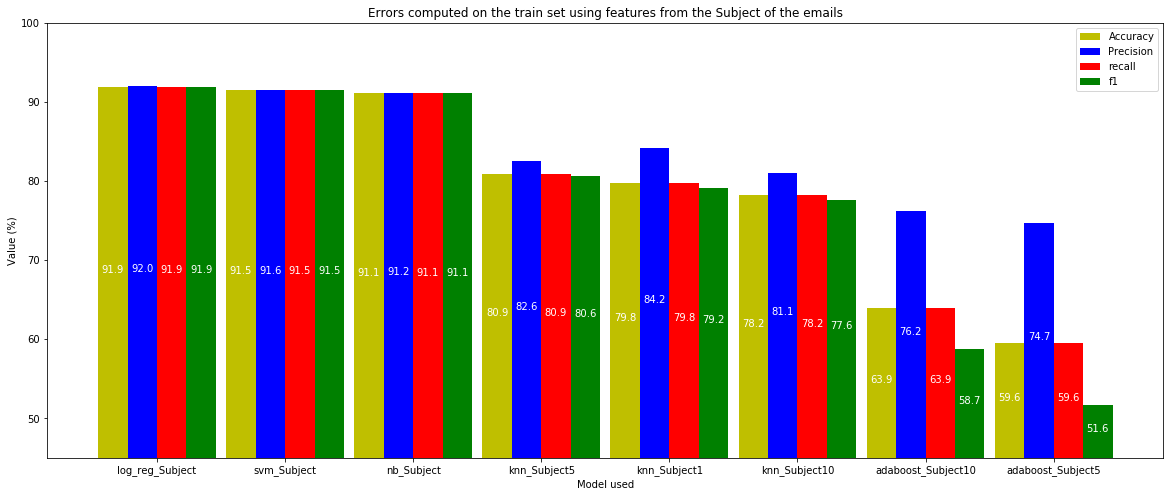

In [3]:
# Plot the errors
def plot_errors(feature_email):
    ind = np.arange(8)
    width = 0.23
    # Get all the errors
    errors_accuracy_values = errors_email[feature_email][ACCURACY].dropna()*100
    errors_precision_values = errors_email[feature_email][PRECISION].dropna()*100
    errors_recall_values = errors_email[feature_email][RECALL].dropna()*100
    errors_f1_values = errors_email[feature_email][F1].dropna()*100
    fig, ax = plt.subplots(figsize=(20, 8))
    # Set 4 bar charts, 1 for each
    rects1 = ax.bar(ind, errors_accuracy_values, width, color='y')
    rects2 = ax.bar(ind + width, errors_precision_values, width, color='b')
    rects3 = ax.bar(ind + 2*width, errors_recall_values, width, color='r')
    rects4 = ax.bar(ind + 3*width, errors_f1_values, width, color='g')
    # Display the value on the bar
    ax.set_ylim([45, 100])
    for stats_tick, value in enumerate(errors_accuracy_values):
        ax.text(stats_tick, 45+(value-45)/2, "{0:.1f}".format(value), horizontalalignment='center', color='white')
    for stats_tick, value in enumerate(errors_precision_values):
        ax.text(stats_tick+width, 45+(value-45)/2, "{0:.1f}".format(value), horizontalalignment='center', color='white')
    for stats_tick, value in enumerate(errors_recall_values):
        ax.text(stats_tick+2*width, 45+(value-45)/2, "{0:.1f}".format(value), horizontalalignment='center', color='white')
    for stats_tick, value in enumerate(errors_f1_values):
        ax.text(stats_tick+3*width, 45+(value-45)/2, "{0:.1f}".format(value), horizontalalignment='center', color='white')
    ax.legend((rects1[0], rects2[0], rects3[0], rects4[0]), (ACCURACY, PRECISION, RECALL, F1))
    ax.set_xticks(ind + 3*width/2)
    ax.set_xticklabels(list(errors_email[feature_email].index))
    plt.title("Errors computed on the train set using features from the " + feature_email + " of the emails")
    plt.xlabel('Model used')
    plt.ylabel('Value (%)')

    return plt

# Show the errors for the subject text feature
plot_errors(SUBJECT).show()

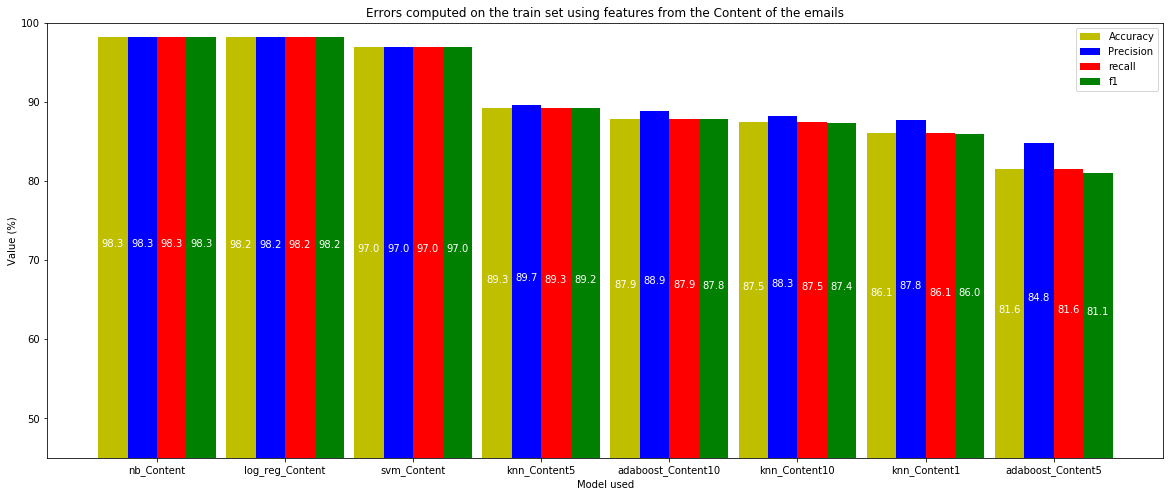

In [4]:
# Show the errors for the subject text feature
plot_errors(CONTENT).show()